Basic pseudotime analysis
=========================

The objective of this notebook is to learn how to perform tree inference from single cell data, starting from a count matrix.
Significant features that significantly changes along the tree will then be extracted and clustered.

## Importing modules and basic settings

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scFates as scf
%matplotlib inline

In [2]:
import sys
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))

## Load and preprocess data

This cell follows the [palantir tutorial notebook](https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb) with some slight changes. Doing palantir diffusion maps is usually a good pre-preprocessing step before using elpigraph or ppt.

### load csv, normalise and log-transform

In [3]:
import palantir
counts = palantir.io.from_csv('https://github.com/dpeerlab/Palantir/raw/master/data/marrow_sample_scseq_counts.csv.gz')
norm_df=sc.pp.normalize_per_cell(counts,copy=True)
norm_df = palantir.preprocess.log_transform(norm_df)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


### Initialise AnnData, find highly variable genes and do PCA

In [4]:
adata=sc.AnnData(norm_df)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor='cell_ranger')
sc.pp.pca(adata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


### Plot first 5 PCs

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


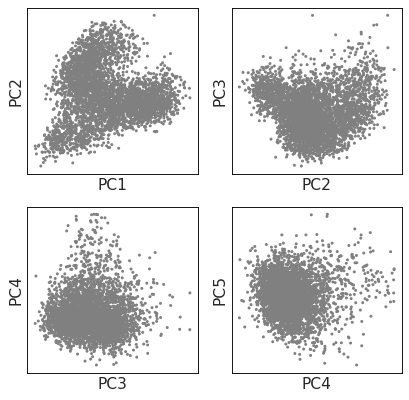

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
sc.settings.set_figure_params(dpi=80, figsize=(6, 6))
fig, axs = plt.subplots (2,2)
sc.pl.pca(adata,components=[1,2],na_color="grey",ax=axs[0,0],show=False)
sc.pl.pca(adata,components=[2,3],na_color="grey",ax=axs[0,1],show=False)
sc.pl.pca(adata,components=[3,4],na_color="grey",ax=axs[1,0],show=False)
sc.pl.pca(adata,components=[4,5],na_color="grey",ax=axs[1,1])

### Generate UMAP embedding

In [6]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [7]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


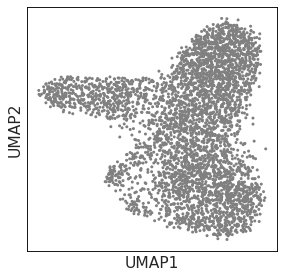

In [8]:
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))
sc.pl.umap(adata,na_color="grey")

## Infer tree on PCA space

In [9]:
scf.tl.tree(adata,Nodes=30,method="epg",use_rep="X_pca",ndims_rep=5)

inferring a principal tree --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:12) --> added 
    .uns['epg'] dictionnary containing inferred elastic tree generated from elpigraph.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] hard assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.


### Visualise tree on PCA space

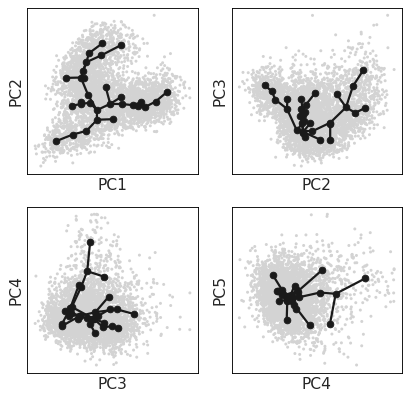

In [10]:
sc.settings.set_figure_params(dpi=80, figsize=(6, 6))
fig, axs = plt.subplots(2,2)
scf.pl.graph(adata,basis="pca",forks=False,tips=False,ax=axs[0,0],show=False,components=[1,2])
scf.pl.graph(adata,basis="pca",forks=False,tips=False,ax=axs[0,1],show=False,components=[2,3])
scf.pl.graph(adata,basis="pca",forks=False,tips=False,ax=axs[1,0],show=False,components=[3,4])
scf.pl.graph(adata,basis="pca",forks=False,tips=False,ax=axs[1,1],show=False,components=[4,5])

### Visualise tree on UMAP embedding

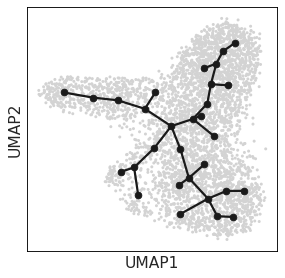

In [11]:
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))
scf.pl.graph(adata,forks=False,tips=False)

## Going beyond PCA: Diffusion maps

### Obtain multiscale diffusio nspace with Palantir

This will be saved in `adata.obsm["X_palantir_multiscale"]`

In [12]:
sce.tl.palantir(adata,impute_data=False,n_eigs=4)

Palantir Diffusion Maps in progress ...
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


### Plot DCs

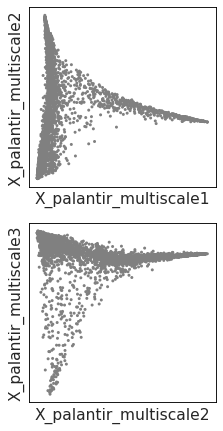

In [13]:
sc.settings.set_figure_params(dpi=80, figsize=(3, 6.5))
fig, axs = plt.subplots(2,1)
sc.pl.embedding(adata,components=[1,2],na_color="grey",basis='X_palantir_multiscale',ax=axs[0],show=False)
sc.pl.embedding(adata,components=[2,3],na_color="grey",basis='X_palantir_multiscale',ax=axs[1])

### Generate ForceAtlas2 embedding

In [14]:
sc.pp.neighbors(adata,use_rep='X_palantir_multiscale',n_neighbors=30)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [15]:
adata.obsm["X_2pcs"]=adata.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata,init_pos="X_2pcs")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:26)


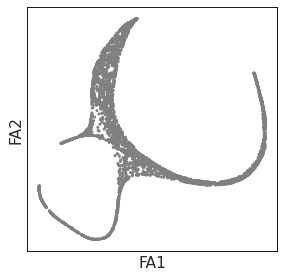

In [16]:
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))
sc.pl.draw_graph(adata,na_color="grey")

## Infer tree on Diffusion space

In [17]:
scf.tl.tree(adata,method="epg",Nodes=30,use_rep="X_palantir_multiscale",seed=1,epg_lambda= .05)

inferring a principal tree --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.05
    finished (0:00:09) --> added 
    .uns['epg'] dictionnary containing inferred elastic tree generated from elpigraph.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] hard assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.


### Visualise tree on diffusion space

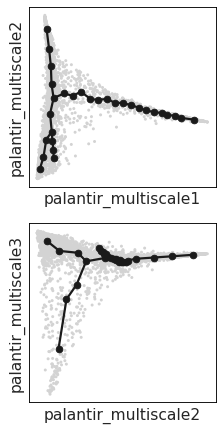

In [18]:
sc.settings.set_figure_params(dpi=80, figsize=(3, 6.5))
fig, axs = plt.subplots(2,1)
scf.pl.graph(adata,basis="palantir_multiscale",forks=False,tips=False,ax=axs[0],show=False,components=[1,2])
scf.pl.graph(adata,basis="palantir_multiscale",forks=False,tips=False,ax=axs[1],show=False,components=[2,3])

### Visualise tree on UMAP embedding

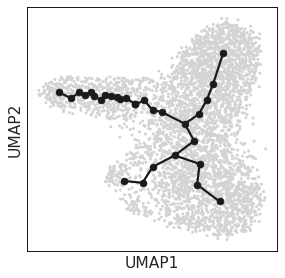

In [19]:
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))
scf.pl.graph(adata,forks=False,tips=False,basis="umap")

### Visualise tree on ForceAtlas2 embedding

Let's display the tip IDs, these will be used to select the root.

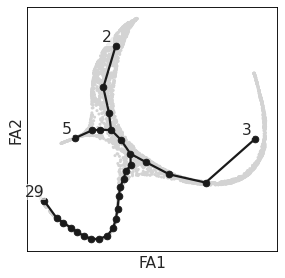

In [20]:
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))
scf.pl.graph(adata,forks=False,tips=True,basis="draw_graph_fa")

### Finding the root using marker

The easiest way of hcoosing the root is to plot a known marker and look at its expression

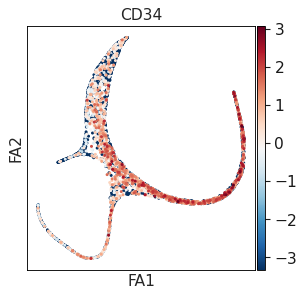

In [21]:
sc.pl.draw_graph(adata,color="CD34",color_map="RdBu_r")

### Selecting root and projecting cells

Using CD34 marker, we can confidently tell that the tip 3 is the root.

In [22]:
scf.tl.root(adata,3)

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Having the root selected, we can now project the cells onto the tree and compute the pseudotime value for each of them.

In [23]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


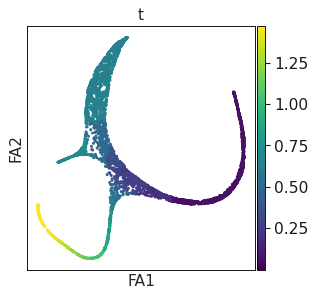

In [24]:
sc.pl.draw_graph(adata,color="t",cmap="viridis")

We can also plot the trajectory colored by its pseudotime, here the cells are colored by segments.

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


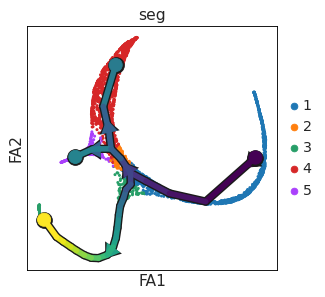

In [25]:
scf.pl.trajectory(adata,basis="draw_graph_fa",
                  color_cells="seg",arrows=True,arrow_offset=1)

## Test and fit associated features associated with the tree

Let's find out which genes are significantly changing along the tree.

<div class="alert alert-warning">
    
**Warning**

This steps takes a long time as it is testing all genes! it is recommend to use a powerful computer with multiple cores.

</div>

In [26]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    mapping 0: 100%|██████████| 16106/16106 [03:44<00:00, 71.67it/s]
    found 3044 significant features (0:03:47) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


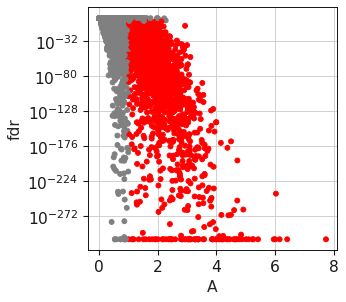

In [27]:
scf.pl.test_association(adata)

We can now fit the significant genes.

<div class="alert alert-warning">
    
**Warning**

anndata format can currently only keep the same dimensions for each of its layers. This means that adding the layer for fitted features will lead to dataset subsetted to only those! 

By default the function fit will keep the whole dataset under **adata.raw** (parameter save_raw)

</div>

In [28]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    mapping 0: 100%|██████████| 3044/3044 [01:43<00:00, 29.46it/s]
    finished (adata subsetted to keep only fitted features!) (0:01:53) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


## Plot single features

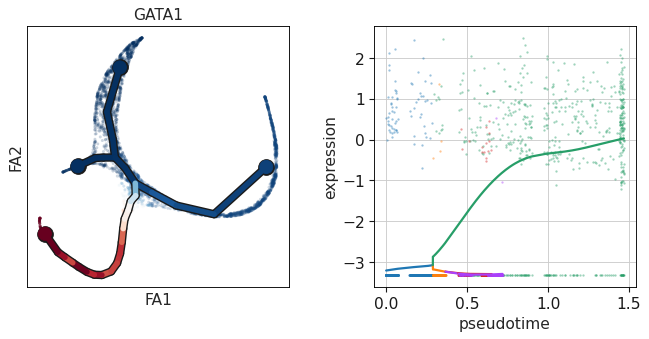

In [29]:
scf.pl.single_trend(adata,feature="GATA1",basis="draw_graph_fa",alpha=.2)

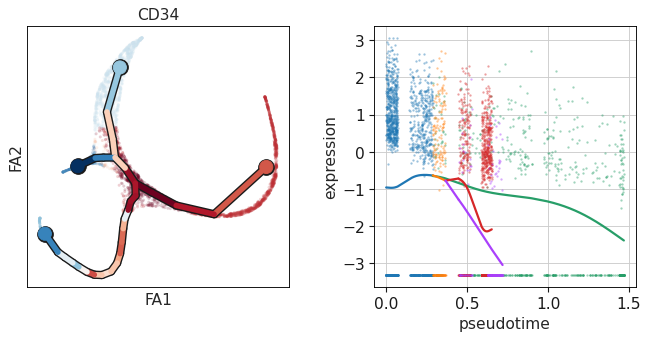

In [30]:
scf.pl.single_trend(adata,feature="CD34",basis="draw_graph_fa",alpha=.2)

## Cluster and plot fitted features

In [31]:
scf.tl.cluster(adata,knn=300,metric="correlation",device="cpu")

    clustering using phenograph
Finding 300 nearest neighbors using correlation metric and 'brute' algorithm
Neighbors computed in 16.233893871307373 seconds
Jaccard graph constructed in 74.38048434257507 seconds
Wrote graph to binary file in 4.17000675201416 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.603843
After 2 runs, maximum modularity is Q = 0.605352
After 8 runs, maximum modularity is Q = 0.608506
Louvain completed 28 runs in 8.916314840316772 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 108.33812022209167 seconds
    finished (0:01:51) --> added
    .var['fit_clusters'], cluster assignments for features.


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


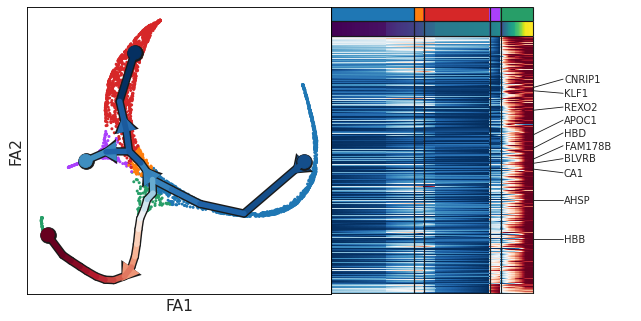

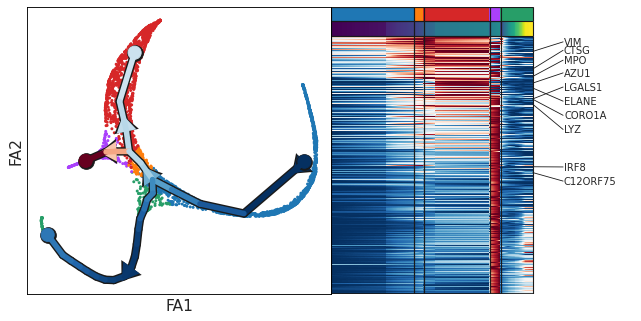

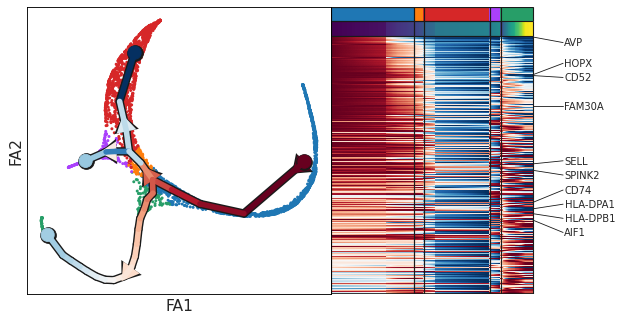

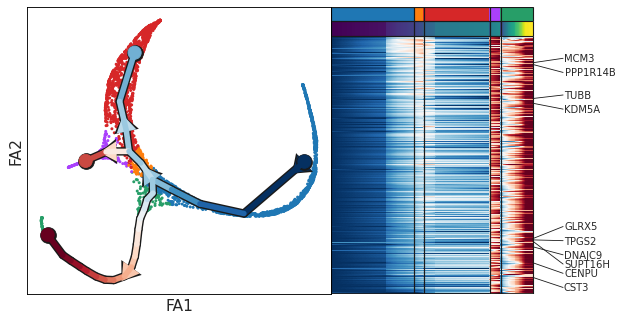

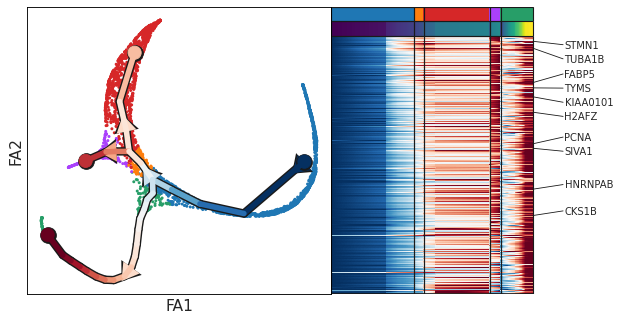

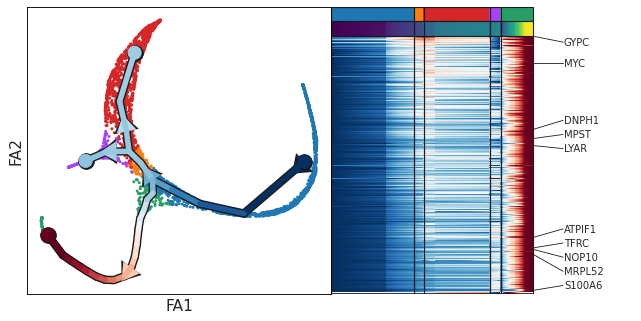

In [32]:
for c in pd.Series(adata.var["fit_clusters"]).unique():
    scf.pl.trends(adata,features=adata.var_names[adata.var.fit_clusters==c],
                  basis="draw_graph_fa",annot="seg",arrows=True,arrow_offset=1)